> Gabriel da Fonseca Nunes - Data Scientist Junior

Problem 3: Regression Analysis
A supermarket company has a new internal policy to not discriminate significantly salary according to the location of their employees. They gathered the data from all of their employees and want you to verify if they are already following the new policy.
Before answering the questions below take a look at the annexed dataset: (1stPhase-SelectiveProcess-Data Science-Data Base.csv)


a)	Question: Describe how can you use the supermarket data to verify if employees from different locations have significantly different salaries ? (Include here how you are going to treat the variables before feeding into the model)

b)	Question: Implement the approach you described in python or r

For this problem, if we only want to know if there is a statistically significant difference in salaries between the groups for the "locations" variable and the company is already following the new policy, we can take a simpler approach without needing to create a regression model. We can simply use the t-test to check if the "locations" variable has a statistical difference in employee salaries (this method compares the distribution between the mean values in the groups). If there is a significant statistical difference, we can then create a regression model to better understand the contribution of the "locations" variable to employee salaries.

1) Firstly, we need to determine the type of "locations" variable. I will use a method to infer the variable type.

In [20]:
# Analize 
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Feature Engeinnering 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    TargetEncoder
)

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

# Evaluate models 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Shap values
import shap

# Divisão dados de treinamento e teste
from sklearn.model_selection import train_test_split as tt_split

dataset = pd.read_excel("./data/1st_Phase_-_Selective_Process_-_Data_Science_-_DataBase.xlsx", engine='openpyxl')

# Removendo a coluna ID
dataset.drop("ID", axis=1, inplace= True)

In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EDUCAÇÃO        80 non-null     object 
 1   CARGO           80 non-null     object 
 2   LOCAL           80 non-null     object 
 3   IDADE           80 non-null     int64  
 4   TEMPOCASA       80 non-null     int64  
 5   SALARIO_MENSAL  80 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 3.9+ KB


In [3]:
def infer_variable_type(dataset):
    """
    Args:
        dataset (pd.DataFrame): It's a dataset
    """
    types = []
    
    for column in dataset.columns:
        unique_vals = dataset[column].unique()
        if dataset[column].dtype == 'object' or len(unique_vals) < len(dataset) * 0.05:
            types.append((column, 'Categorical'))
        else:
            types.append((column, 'Numerical'))
    
    return pd.DataFrame(types, columns=['Variable', 'Type'])

# Example usage:
# Assuming 'dataset' is the DataFrame containing the dataset
variable_types = infer_variable_type(dataset)
display(variable_types)


,Variable,Type
0,EDUCAÇÃO,Categorical
1,CARGO,Categorical
2,LOCAL,Categorical
3,IDADE,Numerical
4,TEMPOCASA,Numerical
5,SALARIO_MENSAL,Numerical


In [4]:
unique_locals = dataset['LOCAL'].unique()
unique_locals

array(['INTERIOR', 'CAPITAL'], dtype=object)

In [5]:
def eval_test_t_student(dataset, feature, target):
    """
    This method applies the t-test method.
    Args:
        dataset: DataFrame containing the data.
        feature: Name of the feature/column to compare groups.
        target: Name of the target variable.
    """
    # Splitting the DataFrame into two groups based on the feature
    unique_values = dataset[feature].unique()
    samples_by_group = [dataset[dataset[feature] == unique_value][target] for unique_value in unique_values]

    # Performing the t-test
    t_statistic, p_value = ttest_ind(*samples_by_group)

    # Printing the results
    print("t-test Statistic:", t_statistic)
    print("p-value:", p_value)

    # Conclusion based on the p-value
    if p_value < 0.05:
        print(f"There is a statistically significant difference between the groups of the variable {feature} and {target}.")
        return True
    else:
        print(f"There is no statistically significant difference between the groups of the variable {feature} and {target}.")
        return False

# Example usage:
# Assuming 'dataset' is the DataFrame containing the dataset
eval_test_t_student(dataset, "LOCAL", "SALARIO_MENSAL")

t-test Statistic: -2.969717893005732
p-value: 0.003959288437224028
There is a statistically significant difference between the groups of the variable LOCAL and SALARIO_MENSAL.


True

In [6]:
# Renomeando 'SALARIO_MENSAL' : 'TARGET'
dataset.rename(columns={'SALARIO_MENSAL': 'TARGET'}, inplace= True)

# Divindo dataset entre features e target
y = dataset["TARGET"].copy()
X = dataset.loc[:, [col for col in dataset.columns if col != "TARGET"]].copy()
X_train, X_test, y_train, y_test = tt_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Define as colunas numéricas e categóricas
numeric_features = [col for col in dataset.columns if dataset[col].dtype != 'O' and col != "TARGET"]
categorical_features = [col for col in dataset.columns if dataset[col].dtype == 'O' and col != "TARGET"]

# Define a pipeline para variáveis categoricas
categorical_pipeline = Pipeline(steps=[
    ('target_encoder', TargetEncoder())
])

# Define a pipeline para padronização
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combinando os pipelines para todas as colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', numeric_pipeline, numeric_features)
])

# Transformando os dados de treino e teste
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

# Transformando os dados de treino e teste para DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=categorical_features + numeric_features)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=categorical_features + numeric_features)

# Concatenando X_train_transformed e X_train_transformed
X_transformed_df = pd.concat([X_train_transformed_df, X_test_transformed_df])
X_transformed = X_transformed_df.values

In [8]:
X_transformed_df

,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA
0,5752.366002,5748.085017,5863.034245,-0.344993,-1.116322
1,5752.366002,5386.860660,5863.034245,0.791455,0.697701
2,5766.335790,5746.996529,5517.534793,-0.035053,-0.976782
3,5780.446679,5729.940354,5416.877845,0.378201,1.116322
4,5766.335790,5746.996529,5517.534793,-0.861561,-0.837242
...,...,...,...,...,...
19,5351.384956,5433.512781,5942.174691,-0.138366,0.558161
20,5351.384956,5760.122816,5942.174691,-1.274814,-0.418621
21,5811.291975,6617.209148,5942.174691,0.894768,0.697701
22,5811.291975,5433.512781,5492.180458,-1.378128,-1.395403


In [9]:
# Renomeando 'SALARIO_MENSAL' : 'TARGET'
dataset.rename(columns={'SALARIO_MENSAL': 'TARGET'}, inplace= True)

# Divindo dataset entre features e target
y = dataset["TARGET"].copy()
X = dataset.loc[:, [col for col in dataset.columns if col != "TARGET"]].copy()
X_train, X_test, y_train, y_test = tt_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Instanciando modelo
model = RandomForestRegressor(n_estimators= 10, n_jobs=-1)

# Realizando a validação cruzada com 3 folds
scores = cross_val_score(model, X_transformed, y, cv=3, scoring='neg_mean_squared_error')

# Convertendo os scores de erro para RMSE
rmse_scores = np.sqrt(-scores)
rmse_scores

array([ 961.04584368,  858.34228733, 2104.44562517])

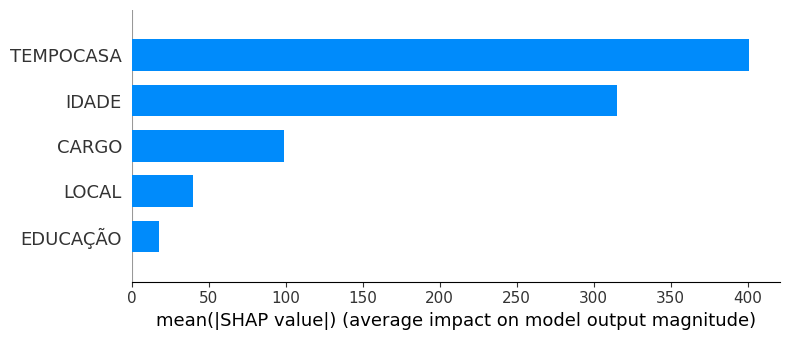

In [15]:
# Train Model
model.fit(X_train_transformed_df, y_train)

#
def plot_shap_values(model, X):
    # Criando o objeto explainer SHAP
    explainer = shap.TreeExplainer(model)
    
    # Calculando os SHAP values
    shap_values = explainer.shap_values(X)
    
    # Plotando o gráfico dos SHAP values
    shap.summary_plot(shap_values, X, plot_type="bar")

plot_shap_values(model, X_train_transformed_df)